In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

In [2]:
data = []
dirs = ['bench', 'out1', 'out2', 'out3', 'out4', 'out5', 'out6', 'out7']
for d in dirs:
	data.append(pd.read_csv(d + '/experiment.csv'))

In [3]:
def plot(data, title='Average payouts with standard deviation'):
	treatments = data['treatment'].unique()
	num_treatments = len(treatments)

	averages = pd.DataFrame(index=range(1, 76), columns=treatments)
	stds = pd.DataFrame(index=range(1, 76), columns=treatments)

	for treatment in treatments:
		round_averages = []
		round_stds = []
		for round in range(1, 76):
			round_df = data.loc[(data['treatment'] == treatment) & (data['round'] == round), ['player1_payout', 'player2_payout']].reset_index(drop=True)
			round_averages.append(((round_df['player1_payout'] + round_df['player2_payout']) / 2).mean())
			round_stds.append(((round_df['player1_payout'] + round_df['player2_payout']) / 2).std())
		averages[treatment] = round_averages
		stds[treatment] = round_stds

	sns.set_theme(style="whitegrid")

	n_cols = 3
	n_rows = math.ceil(num_treatments / n_cols)

	fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
	axs = axs.flatten()

	plt.setp(axs, xlim=(1, 75), ylim=(0, 50))

	for i, treatment in enumerate(treatments):
		mean_vals = averages[treatment]
		std_vals = stds[treatment]
		sns.lineplot(x=mean_vals.index, y=mean_vals, ax=axs[i])

		sns.lineplot(x=range(1, 76), y=[45] * 75, ax=axs[i], color='r', linestyle='--')
		sns.lineplot(x=range(1, 76), y=[36] * 75, ax=axs[i], color='y', linestyle='--')
		sns.lineplot(x=range(1, 76), y=[20] * 75, ax=axs[i], color='g', linestyle='--')

		axs[i].fill_between(mean_vals.index, mean_vals - std_vals, mean_vals + std_vals, color='b', alpha=0.2)
		axs[i].set_title(treatment)
		axs[i].set_xlabel('Round number')
		axs[i].set_ylabel('Average Payout')

	for j in range(len(treatments), len(axs)):
		fig.delaxes(axs[j])

	fig.suptitle(title, fontsize=16)
	plt.tight_layout(rect=[0, 0, 1, 0.96])
	#plt.savefig(f'comparison_plot.pdf')
	plt.show()

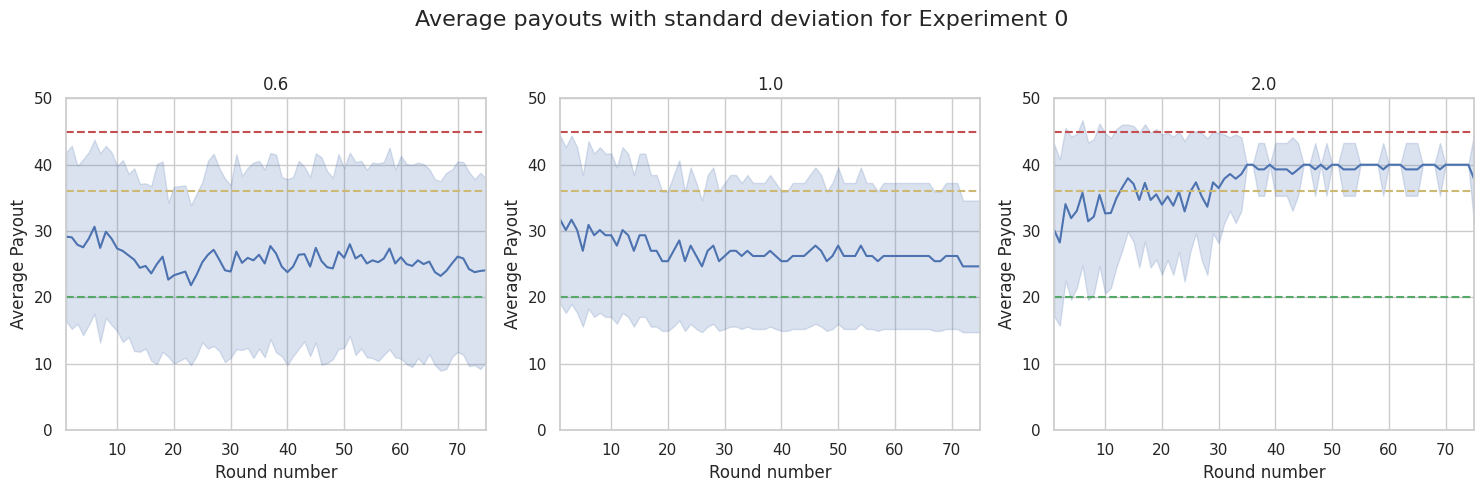

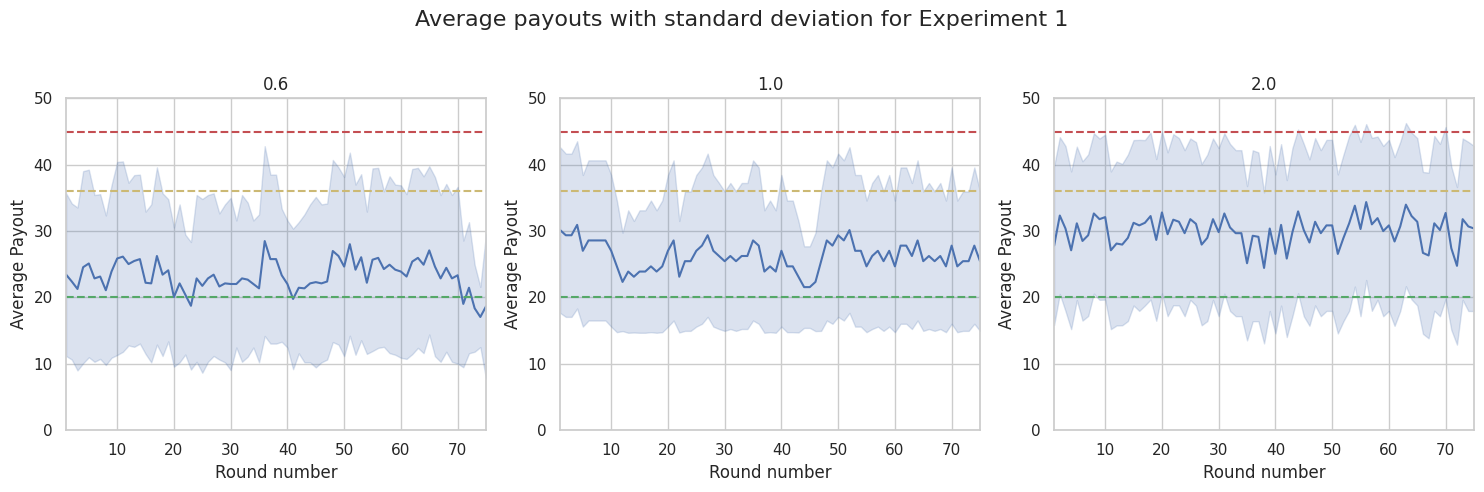

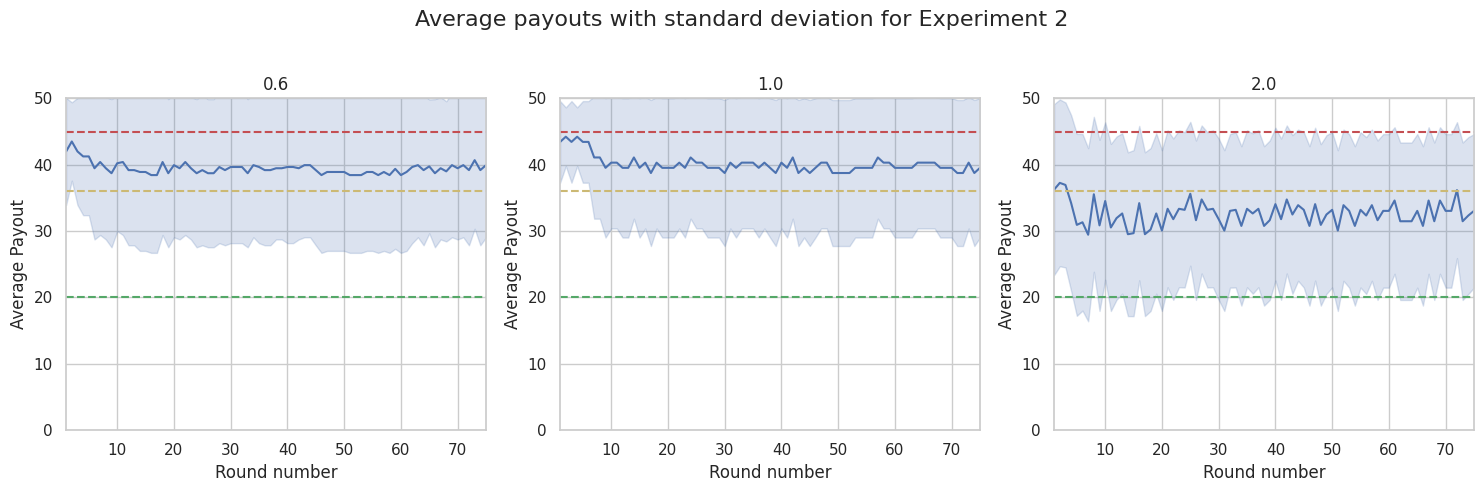

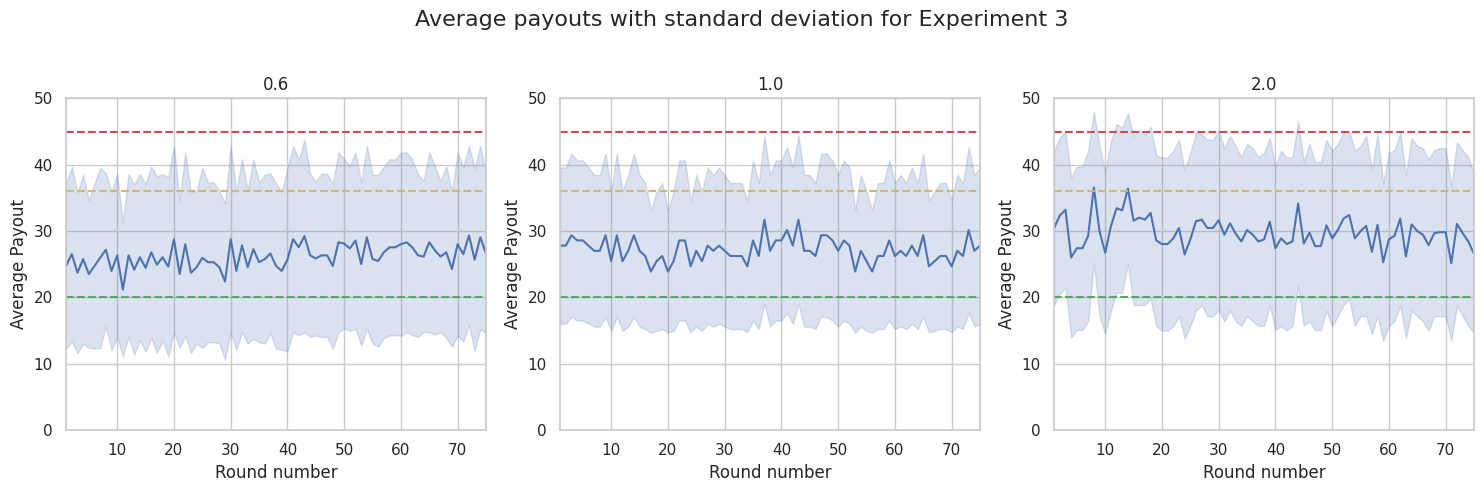

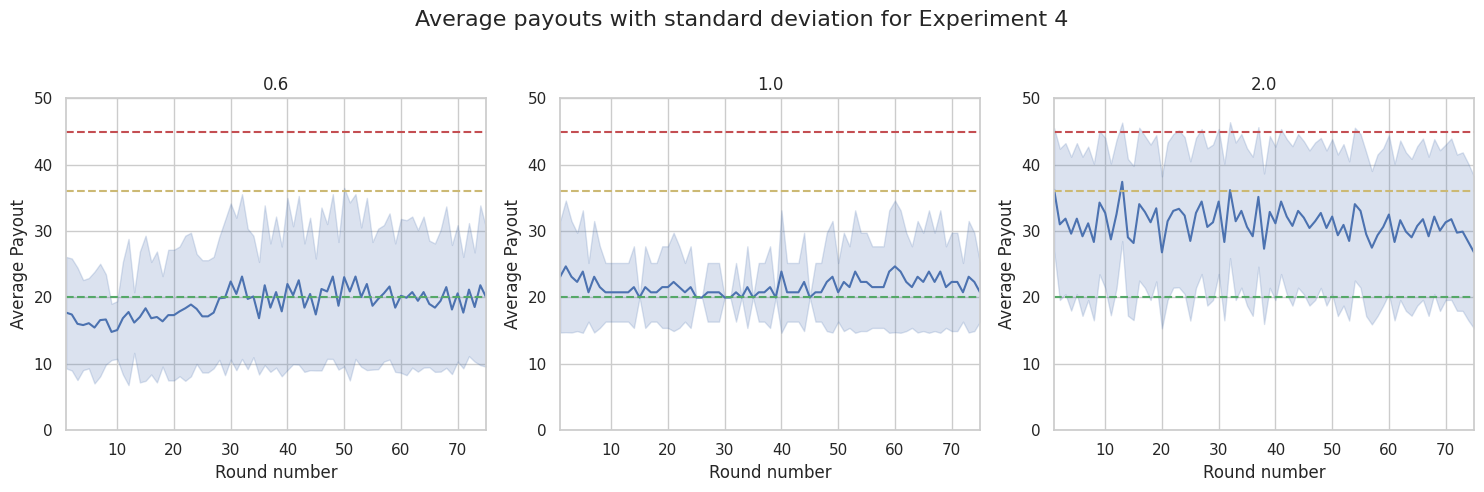

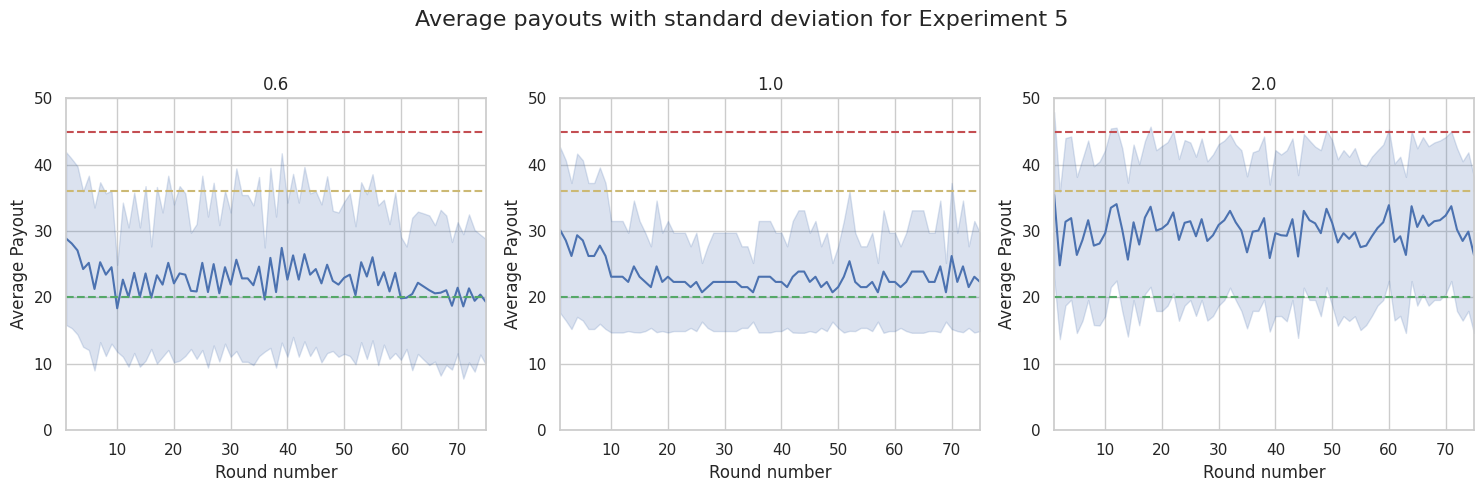

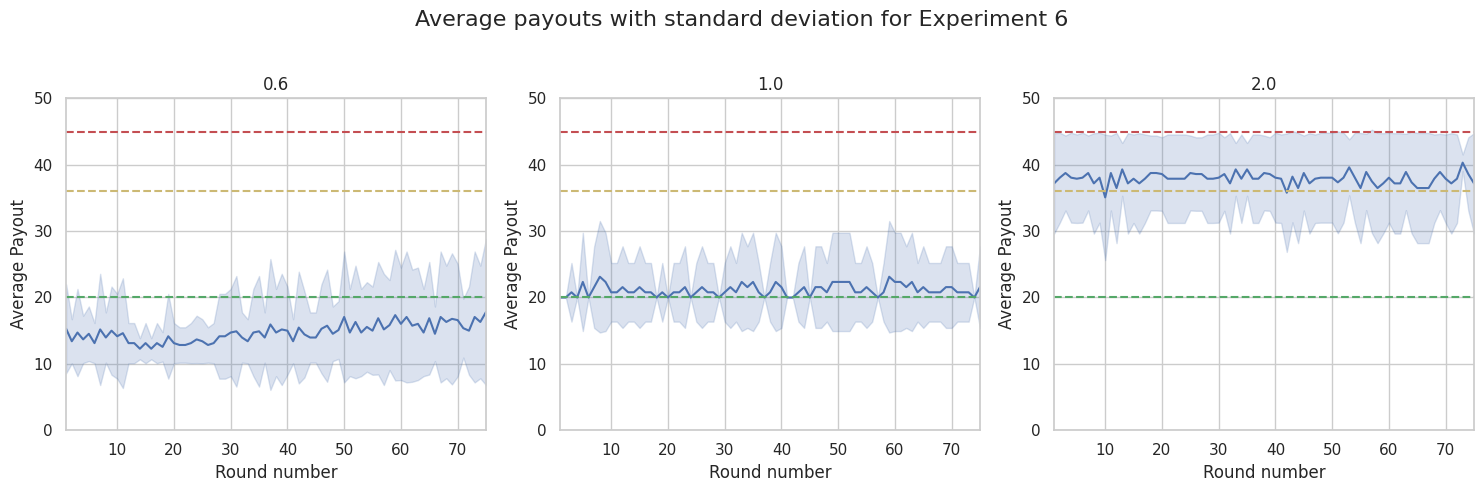

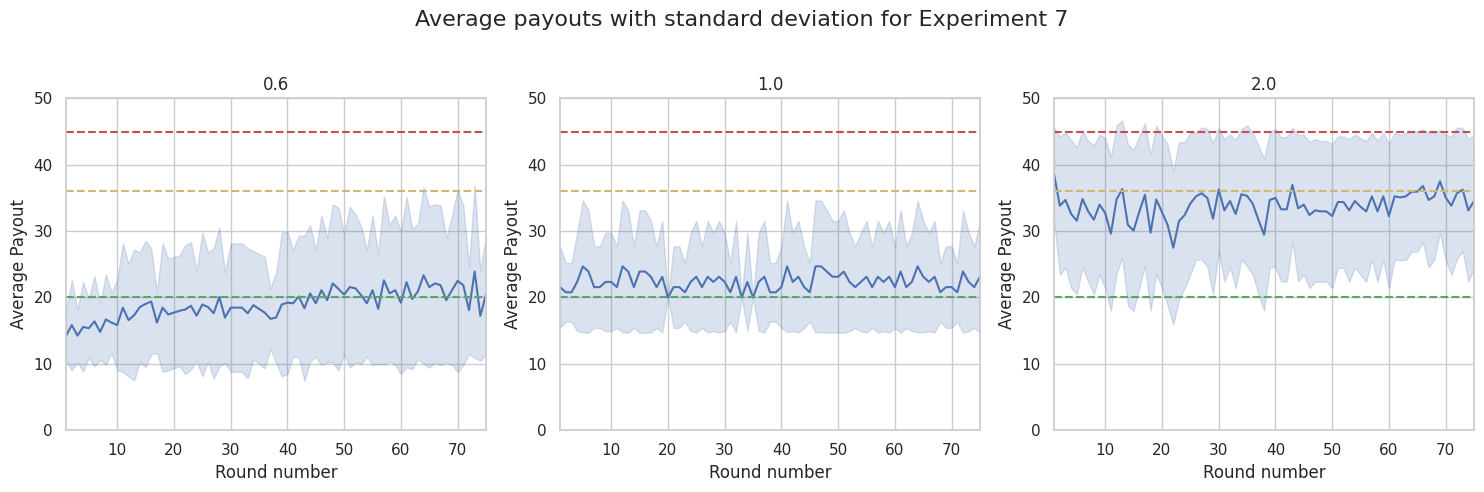

In [4]:
for i, d in enumerate(data):
	plot(d, title=f"Average payouts with standard deviation for Experiment {i}")

In [5]:
def compute_averages(data, treatments):
	averages = pd.DataFrame(index=range(1, 76), columns=treatments)

	for treatment in treatments:
			round_averages = []
			for round in range(1, 76):
				round_df = data.loc[(data['treatment'] == treatment) & (data['round'] == round), ['player1_payout', 'player2_payout']].reset_index(drop=True)
				round_averages.append(((round_df['player1_payout'] + round_df['player2_payout']) / 2).mean())
			averages[treatment] = round_averages
	
	return averages

In [6]:
base_df = data[0]
treatments = base_df['treatment'].unique()
num_treatments = len(treatments)

base_averages = compute_averages(base_df, treatments)

<Axes: >

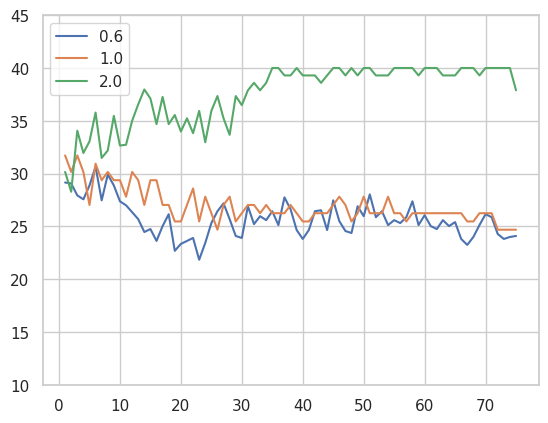

In [7]:
base_averages.plot(ylim=(10, 45))

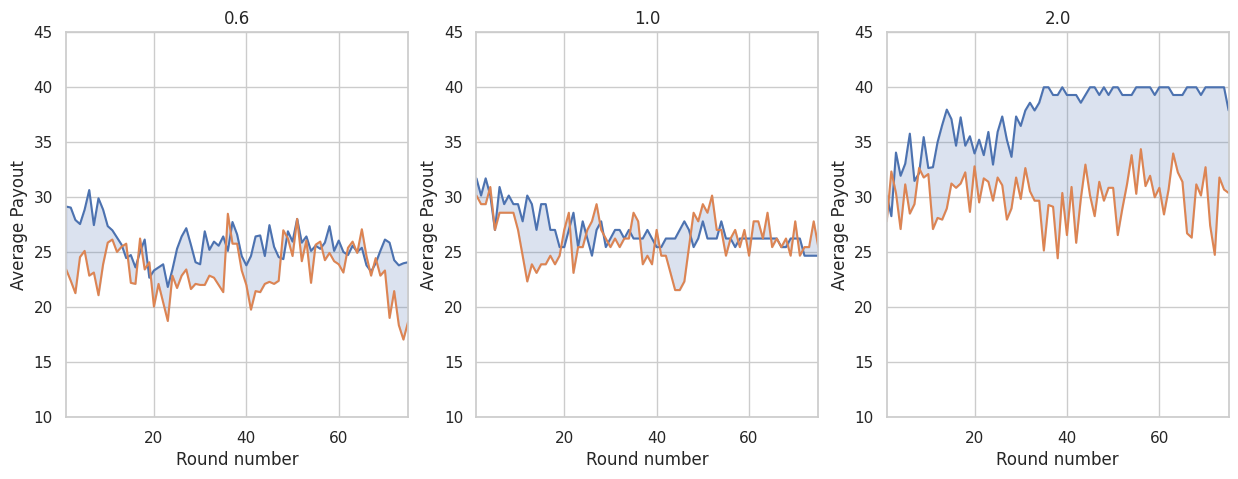

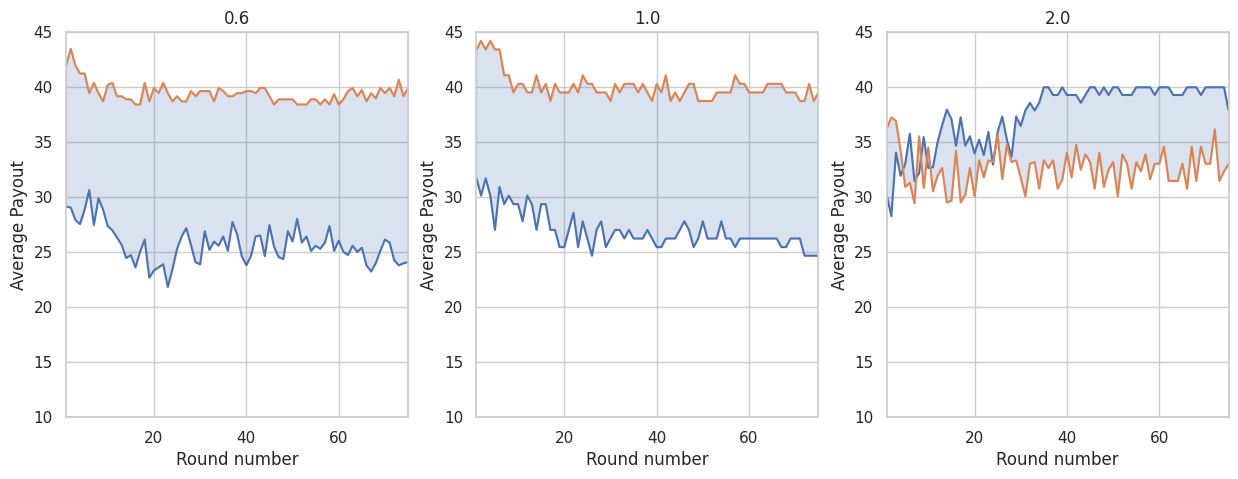

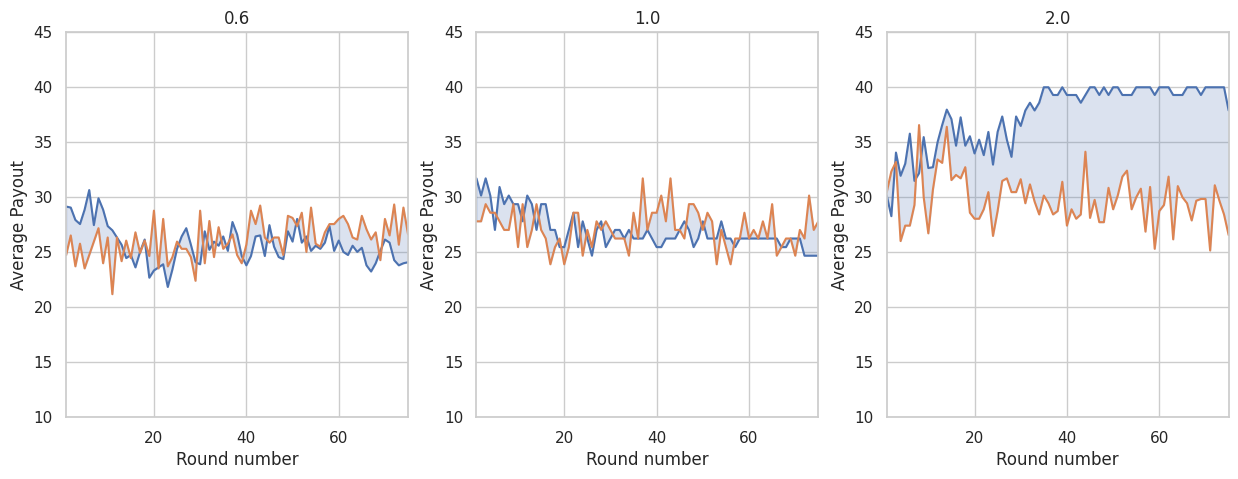

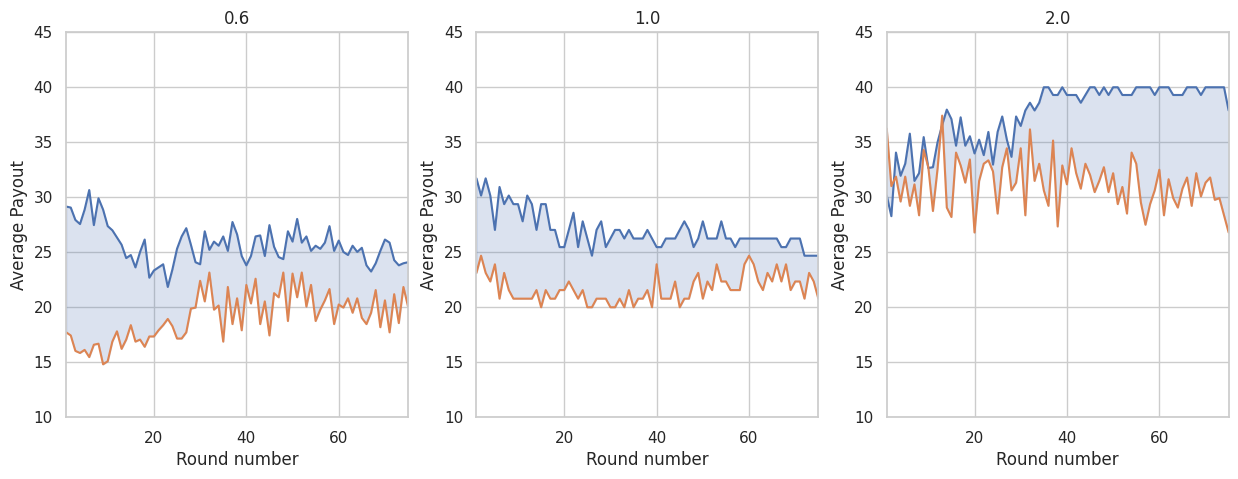

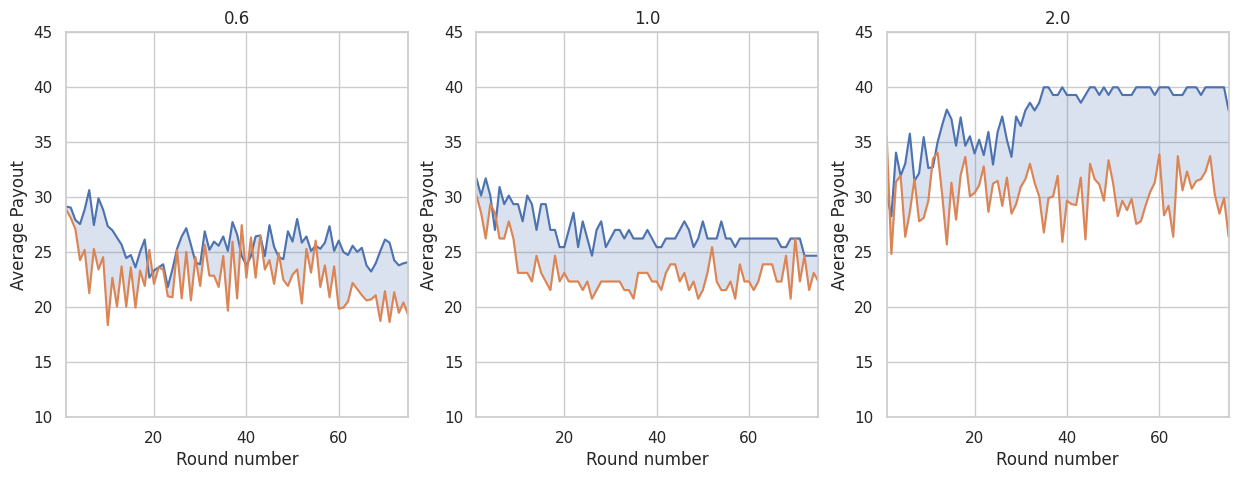

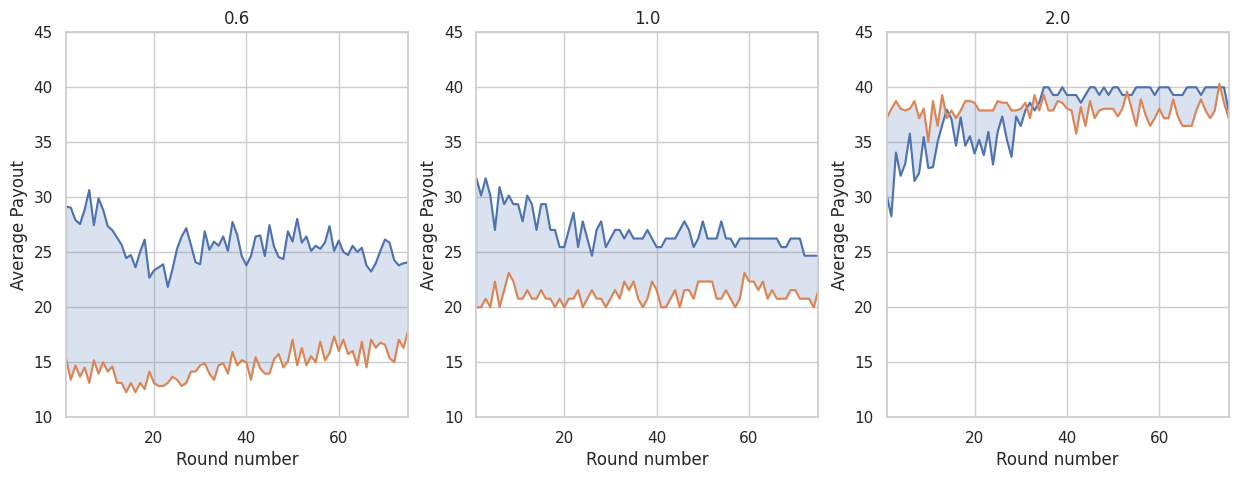

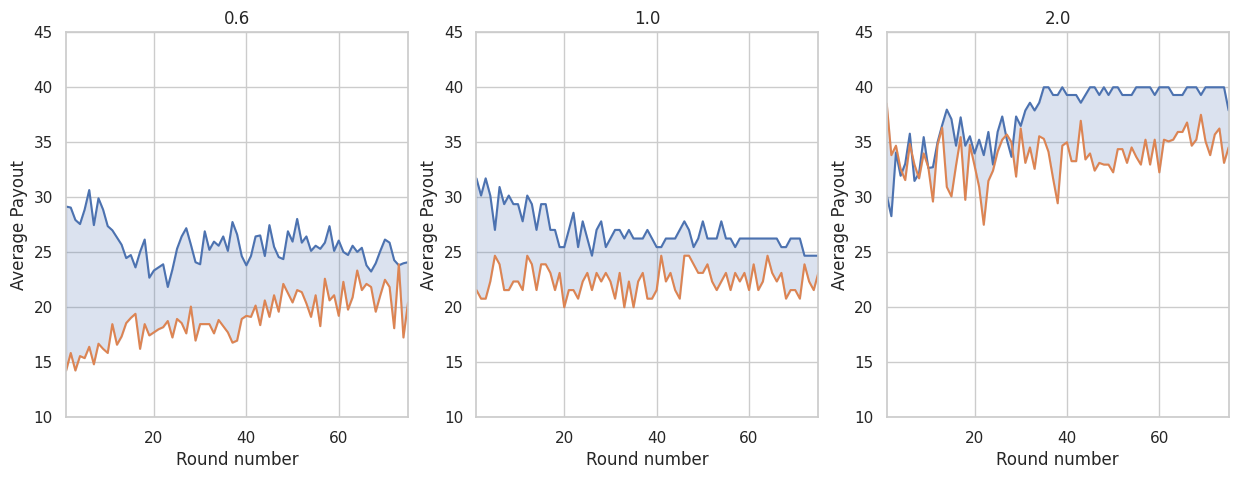

In [8]:
for exp_df in data[1:]:
	exp_averages = compute_averages(exp_df, treatments)
	
	fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
	plt.setp(axs, xlim=(1, 75), ylim=(10, 45))

	for i, treatment in enumerate(treatments):
		base_vals = base_averages[treatment]
		mean_vals = exp_averages[treatment]

		sns.lineplot(x=base_vals.index, y=base_vals, ax=axs[i])
		sns.lineplot(x=mean_vals.index, y=mean_vals, ax=axs[i])
		axs[i].fill_between(mean_vals.index, mean_vals, base_vals, color='b', alpha=0.2)

		axs[i].set_title(treatment)
		axs[i].set_xlabel('Round number')
		axs[i].set_ylabel('Average Payout')

In [9]:
for exp_df in data[1:]:
	exp_averages = compute_averages(exp_df, treatments)

	for treatment in treatments:
		print(stats.ttest_rel(base_averages[treatment], exp_averages[treatment]))
	print("")
	

TtestResult(statistic=8.378686855620078, pvalue=2.4884361300472893e-12, df=74)
TtestResult(statistic=2.6397291075550173, pvalue=0.010113297937223459, df=74)
TtestResult(statistic=17.256590804821155, pvalue=1.1835964897319012e-27, df=74)

TtestResult(statistic=-71.52320613881305, pvalue=4.6839139455476695e-70, df=74)
TtestResult(statistic=-81.14417647289204, pvalue=4.625538413792795e-74, df=74)
TtestResult(statistic=11.408519532403595, pvalue=5.6691971034576076e-18, df=74)

TtestResult(statistic=-1.5987382995741914, pvalue=0.11414015768879637, df=74)
TtestResult(statistic=-0.659727946850383, pvalue=0.5114765301737842, df=74)
TtestResult(statistic=16.998118058218676, pvalue=2.8958797876910335e-27, df=74)

TtestResult(statistic=17.886712759671088, pvalue=1.3823297687150324e-28, df=74)
TtestResult(statistic=22.146439052079845, pvalue=2.22087537452494e-34, df=74)
TtestResult(statistic=13.774852982334293, pvalue=4.100369126849707e-22, df=74)

TtestResult(statistic=10.749951168097622, pvalue=